In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

---
# Directory

In [2]:
os.listdir('../input/deepfake-detection-challenge/')

['train_sample_videos', 'test_videos', 'sample_submission.csv']

In [3]:
json_dir = '../input/deepfake-detection-challenge/train_sample_videos/metadata.json'
train_dir = '../input/deepfake-detection-challenge/train_sample_videos'
test_dir = '../input/deepfake-detection-challenge/test_videos'

In [4]:
train_mov = glob.glob(train_dir + '/*.mp4')
test_mov = glob.glob(test_dir + '/*.mp4')

In [5]:
train_mov[:5]

['../input/deepfake-detection-challenge/train_sample_videos/bbhtdfuqxq.mp4',
 '../input/deepfake-detection-challenge/train_sample_videos/boovltmuwi.mp4',
 '../input/deepfake-detection-challenge/train_sample_videos/bctvsmddgq.mp4',
 '../input/deepfake-detection-challenge/train_sample_videos/eudeqjhdfd.mp4',
 '../input/deepfake-detection-challenge/train_sample_videos/byijojkdba.mp4']

In [6]:
test_mov[:5]

['../input/deepfake-detection-challenge/test_videos/dvwpvqdflx.mp4',
 '../input/deepfake-detection-challenge/test_videos/nthpnwylxo.mp4',
 '../input/deepfake-detection-challenge/test_videos/sqixhnilfm.mp4',
 '../input/deepfake-detection-challenge/test_videos/esjdyghhog.mp4',
 '../input/deepfake-detection-challenge/test_videos/csnkohqxdv.mp4']

In [7]:
metadata = pd.read_json(json_dir).T

In [8]:
metadata.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [9]:
# Label
metadata['label'].value_counts()

FAKE    323
REAL     77
Name: label, dtype: int64

In [10]:
# Label='REAL'
# All of 'original' are 'None'
metadata['original'].value_counts()[metadata[metadata['label'] == 'REAL'].index]

abarnvbtwb.mp4    1.0
aelfnikyqj.mp4    NaN
afoovlsmtx.mp4    1.0
agrmhtjdlk.mp4    NaN
ahqqqilsxt.mp4    NaN
                 ... 
ekcrtigpab.mp4    1.0
ellavthztb.mp4    2.0
eqnoqyfquo.mp4    NaN
erlvuvjsjf.mp4    NaN
eudeqjhdfd.mp4    NaN
Name: original, Length: 77, dtype: float64

In [11]:
metadata[metadata['original'] == 'ellavthztb.mp4']

,label,split,original
bnjcdrfuov.mp4,FAKE,train,ellavthztb.mp4
dbzpcjntve.mp4,FAKE,train,ellavthztb.mp4


In [12]:
video_1 = os.path.join(train_dir, 'bnjcdrfuov.mp4')
video_2 = os.path.join(train_dir, 'dbzpcjntve.mp4')
video_real = os.path.join(train_dir, 'ellavthztb.mp4')

---
# Movie

In [13]:
def get_img_from_mov(video_file, show_img=False):
    # https://note.nkmk.me/python-opencv-videocapture-file-camera/
    cap = cv2.VideoCapture(video_file)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    image_list = []
    for i in range(frames):
        _, image = cap.read()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_list.append(image)
    cap.release()

    if show_img:
        fig, ax = plt.subplots(1,1, figsize=(15, 15))
        ax.imshow(image[0])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.title.set_text(f"FRAME 0: {video_file.split('/')[-1]}")
        plt.grid(False)
        
    return image_list

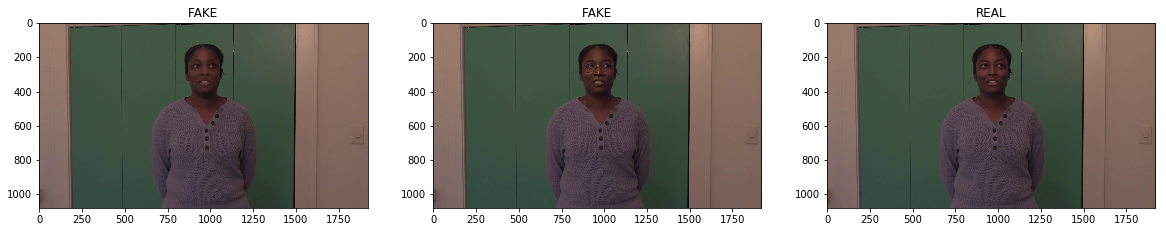

In [14]:
image_1 = get_img_from_mov(video_1)
image_2 = get_img_from_mov(video_2)
image_real = image = get_img_from_mov(video_real)

fig, axes = plt.subplots(1, 3, figsize=(20, 14), facecolor='w')

axes[0].imshow(image_1[0])
axes[0].set_title('FAKE')
axes[1].imshow(image_2[0])
axes[1].set_title('FAKE')
axes[2].imshow(image_real[0])
axes[2].set_title('REAL')
plt.show()

---
# Face Detection

In [15]:
# Add Dataset "Haarcascades"
face_cascade = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_alt.xml')

In [16]:
def detect_face(img):
    face_crops = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)
    
    if len(face_crops) == 0:
        print('no faces found')
        return []
    
    crop_imgs = []
    for i in range(len(face_crops)):
        x = face_crops[i][0]
        y = face_crops[i][1]
        w = face_crops[i][2]
        h = face_crops[i][3]
        #x,y,w,h=ratio*x,ratio*y,ratio*w,ratio*h
        crop_imgs.append(img[y:y+h, x:x+w])
    return crop_imgs

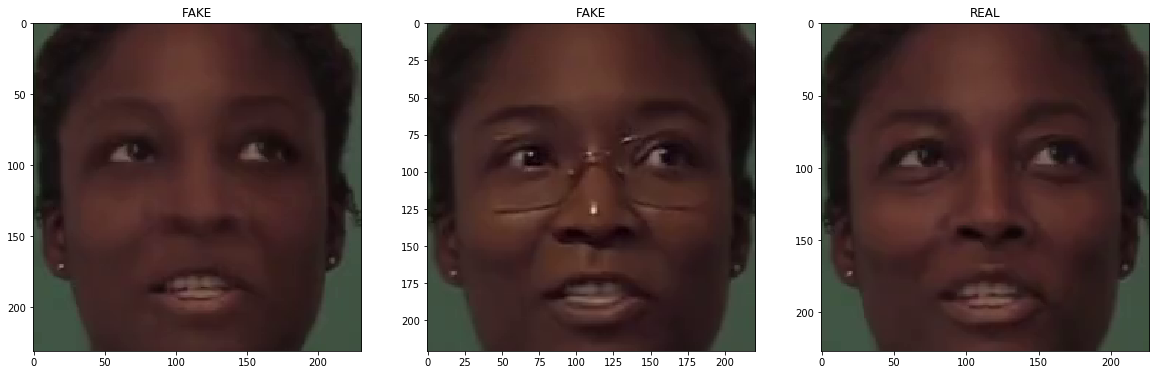

In [17]:
image_crop_1 = detect_face(image_1[0])
image_crop_2 = detect_face(image_2[0])
image_crop_real = detect_face(image_real[0])

fig, axes = plt.subplots(1, 3, figsize=(20, 14), facecolor='w')

axes[0].imshow(image_crop_1[0])
axes[0].set_title('FAKE')
axes[1].imshow(image_crop_2[0])
axes[1].set_title('FAKE')
axes[2].imshow(image_crop_real[0])
axes[2].set_title('REAL')
plt.show()

In [18]:
ss = pd.read_csv("/kaggle/input/deepfake-detection-challenge/sample_submission.csv")
ss['label'] = 0.55
ss.loc[ss['filename'] == 'aassnaulhq.mp4', 'label'] = 0 # Guess the true value
ss.loc[ss['filename'] == 'aayfryxljh.mp4', 'label'] = 0
ss.to_csv('submission.csv', index=False)